In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [63]:
split_cost_csv_file="split-cost-allocation.csv"

# columns in the CUR csv file
account_id = "lineItem/UsageAccountId"
region = "product/region" 
product = "product/ProductName"
lineitem = "lineItem/Operation"
ec2_id = "splitLineItem/ParentResourceId"
split_cost = "splitLineItem/SplitCost"
split_unused_cost = "splitLineItem/UnusedCost"
ecs_service_name = "resourceTags/aws:ecs:serviceName"
ecs_task_id = "lineItem/ResourceId"
usage_hour = "lineItem/UsageStartDate"
usage_type = "lineItem/UsageType"
# usage type is CPU - USE2-ECS-EC2-vCPU-Hours or Memory - USE2-ECS-EC2-GB-Hours 

# values of interest, change these as needed 

account_id_val = 22457860714
region_val = "us-east-2"
product_val = "Amazon Elastic Container Service"
lineitem_val = "ECSTask-EC2"
usage_type_cpu = "vCPU-Hours"
usage_type_mem = "GB-Hours"

In [64]:
# read csv and check its size as quick test for successful read
csv_df = pd.read_csv(split_cost_csv_file)
print(csv_df.shape)

/var/folders/72/5cq9cr2j3kq3f330rl9f1cghw8nkx5/T/ipykernel_62731/3168562036.py:2: DtypeWarning: Columns (16,30,31,32,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,50,51,52,53,54,55,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,73,74,75,76,77,78,79,81,82,83,84,85,86,87,88,90,91,93,94,96,100,101,102,103,104,105,106,107,108,109,110,111,112,115,116,117,118,151,160,161,162,163,164,165,166,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204) have mixed types. Specify dtype option on import or set low_memory=False.
  csv_df = pd.read_csv(split_cost_csv_file)


(90735, 205)


In [65]:
# filter for the ECS EC2 data, for specific region, and specific account


df = csv_df[(csv_df[product] == product_val)&\
            (csv_df[lineitem] == lineitem_val)&\
            (csv_df[region] == region_val)&\
            (csv_df[account_id] == account_id_val)]
# remove other columns that we don't care
df = df[[account_id, region, product, lineitem, ec2_id, split_cost, \
         split_unused_cost, ecs_service_name, ecs_task_id, usage_hour, usage_type]]
print(df.shape)


(1916, 11)


In [70]:
display(HTML(df.head(10).to_html()))

,lineItem/UsageAccountId,product/region,product/ProductName,lineItem/Operation,splitLineItem/ParentResourceId,splitLineItem/SplitCost,splitLineItem/UnusedCost,resourceTags/aws:ecs:serviceName,lineItem/ResourceId,lineItem/UsageStartDate,lineItem/UsageType
2742,22457860714,us-east-2,Amazon Elastic Container Service,ECSTask-EC2,i-0c12ce0a4c7b0e7ed,0.000773,0.038198,NaN,arn:aws:ecs:us-east-2:022457860714:task/core-infra/d46a4d1be9b647f29fbcce7dc1173b8f,2023-06-01T20:00:00Z,USE2-ECS-EC2-GB-Hours
2743,22457860714,us-east-2,Amazon Elastic Container Service,ECSTask-EC2,i-053951dd43eab2d8e,0.006558,0.052179,NaN,arn:aws:ecs:us-east-2:022457860714:task/core-infra/8dbeb831b21f420398c3ecd17d0a8f27,2023-06-01T21:00:00Z,USE2-ECS-EC2-GB-Hours
2744,22457860714,us-east-2,Amazon Elastic Container Service,ECSTask-EC2,i-058da78ce82673af4,0.000037,0.059040,NaN,arn:aws:ecs:us-east-2:022457860714:task/core-infra/7acbb3ffc1284700bff65cbebb6acf80,2023-06-01T21:00:00Z,USE2-ECS-EC2-GB-Hours
2745,22457860714,us-east-2,Amazon Elastic Container Service,ECSTask-EC2,i-0d9718cffeb64c9be,0.007067,0.052010,NaN,arn:aws:ecs:us-east-2:022457860714:task/core-infra/8ac8a163c9ec46c6a8afbd4be0bd045a,2023-06-01T21:00:00Z,USE2-ECS-EC2-GB-Hours
2746,22457860714,us-east-2,Amazon Elastic Container Service,ECSTask-EC2,i-053951dd43eab2d8e,0.007385,0.051692,NaN,arn:aws:ecs:us-east-2:022457860714:task/core-infra/8dbeb831b21f420398c3ecd17d0a8f27,2023-06-01T22:00:00Z,USE2-ECS-EC2-GB-Hours
2747,22457860714,us-east-2,Amazon Elastic Container Service,ECSTask-EC2,i-0711bf33fd885a5a3,0.007385,0.022154,NaN,arn:aws:ecs:us-east-2:022457860714:task/core-infra/8c6f51627036462b8553841693020b4f,2023-06-01T22:00:00Z,USE2-ECS-EC2-GB-Hours
2748,22457860714,us-east-2,Amazon Elastic Container Service,ECSTask-EC2,i-0711bf33fd885a5a3,0.007385,0.022154,NaN,arn:aws:ecs:us-east-2:022457860714:task/core-infra/dcc9513bf4274e429cd15faa6fd6e8dd,2023-06-01T22:00:00Z,USE2-ECS-EC2-GB-Hours
2749,22457860714,us-east-2,Amazon Elastic Container Service,ECSTask-EC2,i-0c12ce0a4c7b0e7ed,0.007385,0.022154,NaN,arn:aws:ecs:us-east-2:022457860714:task/core-infra/69dffda01af743beb4455bc9b1b780a7,2023-06-01T22:00:00Z,USE2-ECS-EC2-GB-Hours
2750,22457860714,us-east-2,Amazon Elastic Container Service,ECSTask-EC2,i-053951dd43eab2d8e,0.007385,0.051692,NaN,arn:aws:ecs:us-east-2:022457860714:task/core-infra/8dbeb831b21f420398c3ecd17d0a8f27,2023-06-01T23:00:00Z,USE2-ECS-EC2-GB-Hours
2751,22457860714,us-east-2,Amazon Elastic Container Service,ECSTask-EC2,i-0711bf33fd885a5a3,0.007385,0.006269,NaN,arn:aws:ecs:us-east-2:022457860714:task/core-infra/dcc9513bf4274e429cd15faa6fd6e8dd,2023-06-01T23:00:00Z,USE2-ECS-EC2-GB-Hours


In [75]:
# get the sum of split cost and unused cost grouped by ecs service name
# you must have enabled ECS Managed Tag, set Propagate Tag to SERVICE, 
# and activated these ECS managed tags for use in cost report

#total_cost_by_service = df.groupby(ecs_service_name)[split_cost, split_unused_cost].sum()

pivot_df = pd.pivot_table(df, values=[split_cost, split_unused_cost], index=ecs_service_name,
                       columns=usage_type, aggfunc=np.sum)
display(HTML(pivot_df.to_html()))

In [77]:
service_names = df[ecs_service_name].dropna().unique()
usage_types = df[usage_type].dropna().unique()
print(usage_types)

['USE2-ECS-EC2-GB-Hours' 'USE2-ECS-EC2-vCPU-Hours']


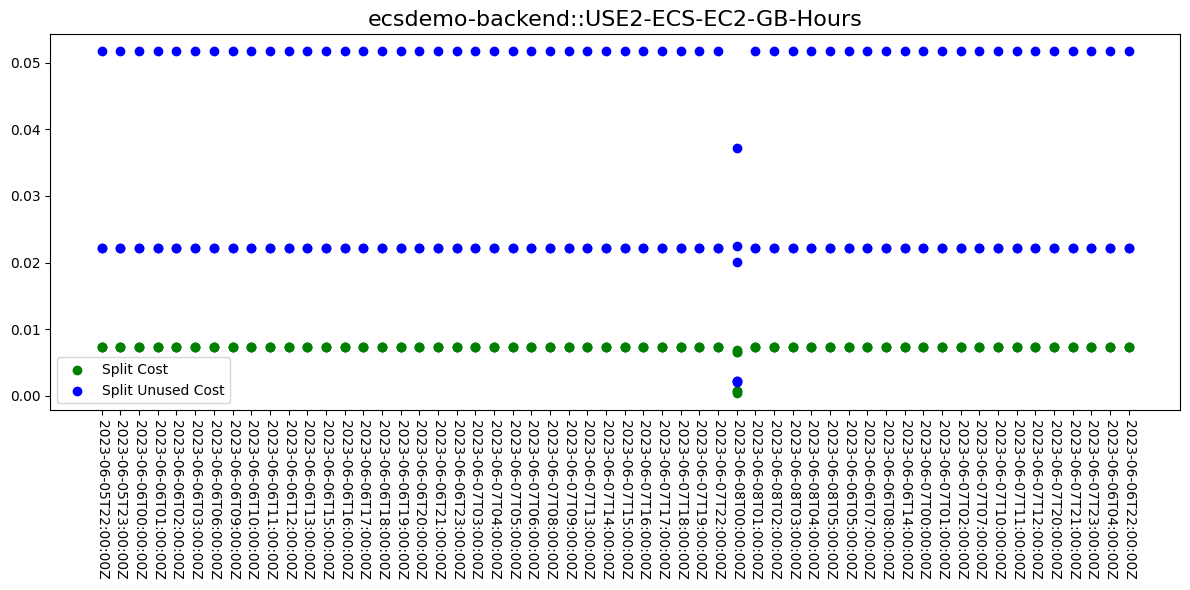

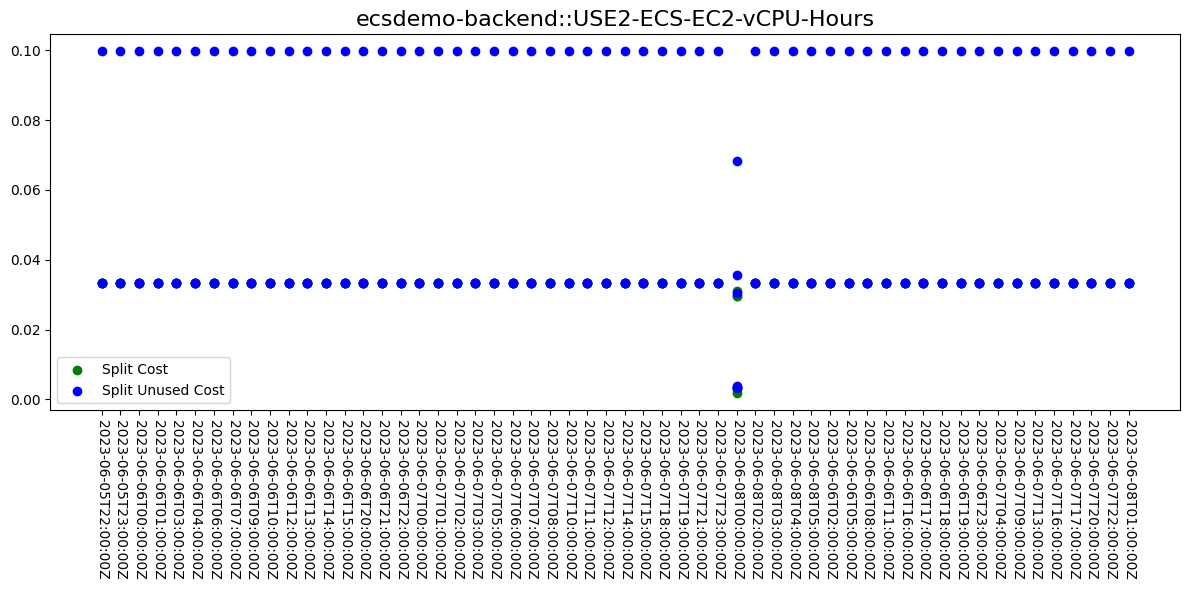

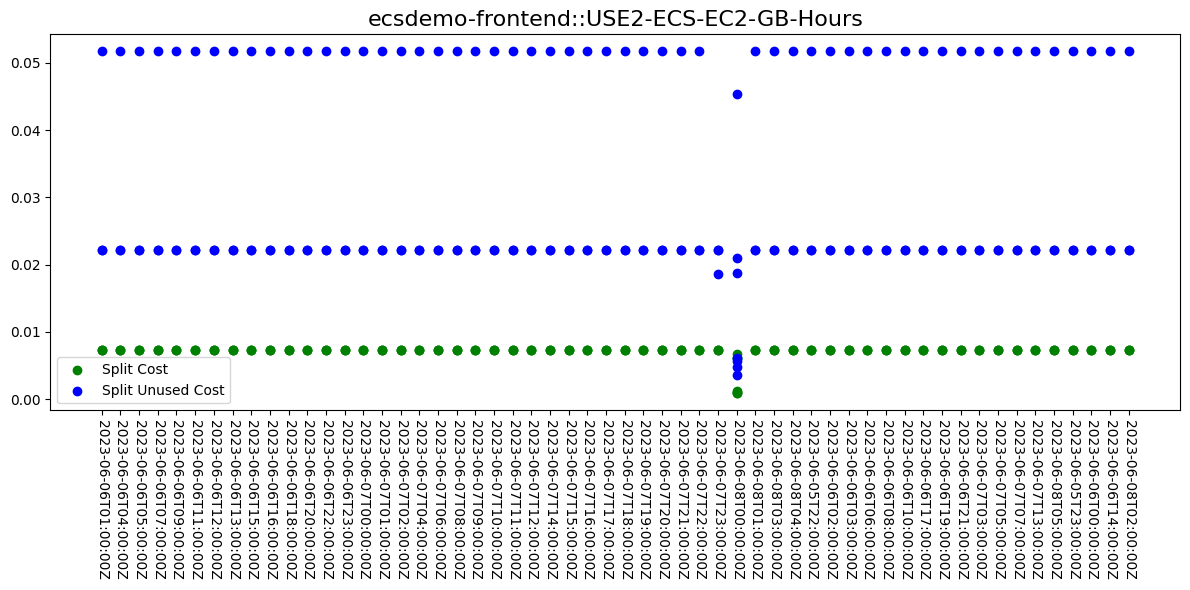

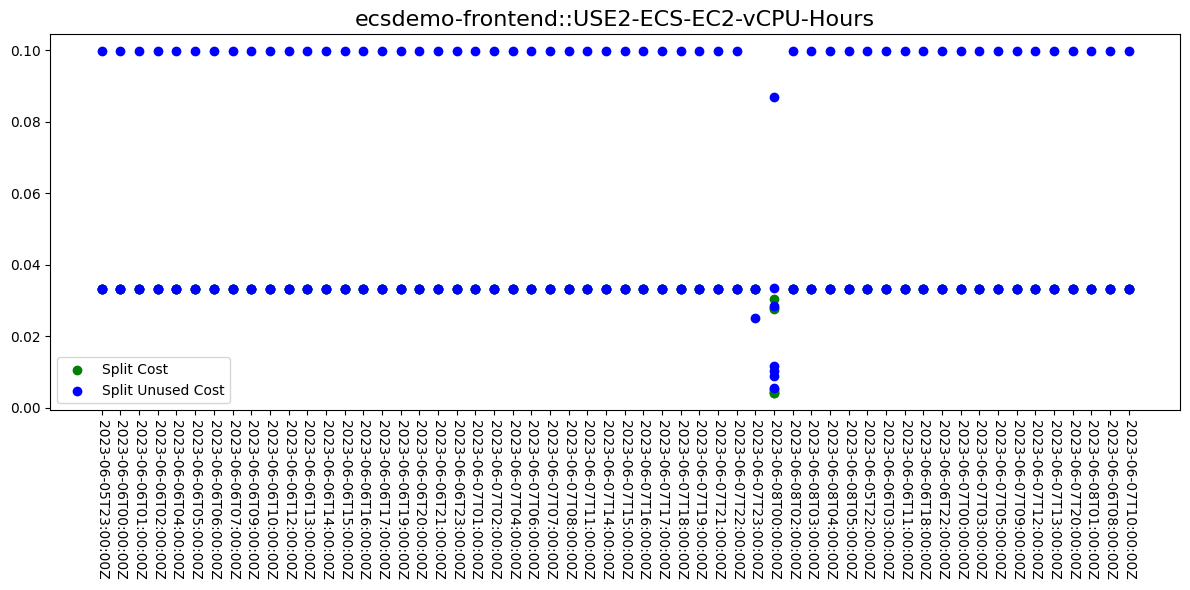

In [80]:

for svc_name in service_names:
    for ut in usage_types:
        plt_df = df[(df[ecs_service_name]==svc_name)&(df[usage_type]==ut)]
        plt.rcParams["figure.figsize"] = [12, 6]
        plt.rcParams["figure.autolayout"] = True
        plt.scatter(x=plt_df[usage_hour], y=plt_df[split_cost], label="Split Cost", color="green")
        plt.scatter(x=plt_df[usage_hour], y=plt_df[split_unused_cost], label="Split Unused Cost", color="blue")
        plt.xticks(rotation=270)
        plt.legend()
        plt.title(svc_name+"::"+ut, fontsize=16)
        plt.show()
    